# Case Study 4

Let us import some libraries.

In [1]:
import math as m
import numpy as np
import time

import matplotlib.pyplot as plt

from scipy.optimize import fmin, fmin_bfgs

from scipy.stats import norm

## 1. Extended Kalman Filter

Let us estimate the parameters of the Heston Stochastic Volatility Model via Extended Kalman Filter.

First let us define the parameters of the Heston model, given in the guidelines.

In [2]:
mu = 0.02
kappa = 1.5
theta = 0.05
lambda_ = 0.18
rho = 0.5
v_0 = 0.04

### 1.1 Functions definition

Let us define a bunch of functions.

First the heston simulator function.

In [3]:
def heston_sim(params, N = 500, dt = 1/100, S0 = 100):
    
    mu, kappa, theta, lambda_, rho, v_0 = params
    
    y = np.matrix(np.zeros((2, N+1)))
    
    y[0,0] = np.log(S0)
    y[1,0] = v_0

    Q = np.matrix([[1, rho],[rho, 1]])

    for i in range(1, N+1):
        Z1, Z2 = np.random.multivariate_normal([0,0], Q)
        
        v = max(y[1,i-1], 0)
        
        y[0, i] = y[0, i-1] + (mu-1/2*v)*dt + np.sqrt(v*dt)*Z1
        y[1, i] = y[1, i-1] + kappa*(theta-v)*dt + lambda_*np.sqrt(v*dt)*Z2
    return y

Then the Extended Kalman Filter function.

In [4]:
def ext_Kalman_filter(params):
    
    global y_KF, v_KF
    
    # We extract the parameters
    
    mu, kappa, theta, lambda_, rho, v_0 = params
        
    # We intialize the matrices and variables
        
    F = np.matrix([[1, -1/2*dt],[0, 1-kappa*dt]])
    U = np.matrix([[np.sqrt(v_0*dt), 0],[0, lambda_*np.sqrt(v_0*dt)]])
    Q = np.matrix([[1, rho],[rho, 1]])
    H = np.matrix([1,0])
    P = np.matrix([[0.01, 0],[0, 0.01]])
    I = np.identity(2)
    
    x_update = np.matrix([m.log(S0), v_0]).T
    
    y_KF = np.zeros(N)
    v_KF = np.zeros(N)
    
    # Calculation of the objective value that we want to minimize
    
    func_obj = 0
    for i in range(1, N):
        
        x_pr = np.matrix([0,0], dtype=np.float64).T
        
        x_pr[0,0] = x_update[0,0] + (mu-1/2*x_update[1,0])*dt
        x_pr[1,0] = x_update[1,0] + kappa*(theta-x_update[1,0])*dt
        
        P_pr = F*P*F.T + U*Q*U.T
        
        A = H*P_pr*H.T
        
        A = A[0,0]
        
        # Error
        
        err = y[i] - x_pr[0,0]
        
        func_obj += np.log(abs(A)) + err**2/A
        
        # Measurement
        
        K = P_pr*H.T/A
        
        x_update = x_pr + K*err
        
        # Make sure that the volatilty is not negative
            
        x_update[1,0] = max(1e-6, x_update[1,0]) 
        
        vk = x_update[1,0]
        
        U = np.matrix([[np.sqrt(vk*dt), 0],[0, lambda_*np.sqrt(vk*dt)]])
        
        P = (I-K*H)*P_pr
        
        y_KF[i] = x_update[0,0]
        v_KF[i] = x_update[1,0]
        
    return func_obj/N
    

Now let us define different variables to estimates the parameters of the model.

In [5]:
# The number of years where we simulate data

nb_years = 10

# Choice of discretization

N = 1000

dt = nb_years/N

# Define the stock price

S0 = 2000

We define the good values for the parameters we want to estimate (i.e., the values given in the guidelines: $\Theta = \{0.02, 1.5, 0.05, 0.18, 0.5, 0.04\}$).

In [6]:
params_good = (mu, kappa, theta, lambda_, rho, v_0)

### 1.2 Simulation

We simulate the heston model for the variables define before.

In [7]:
x = heston_sim(params_good, N, dt, S0)

Let us plot the price (in log scale) evolution in function of the number of years.

Text(0, 0.5, 'price')

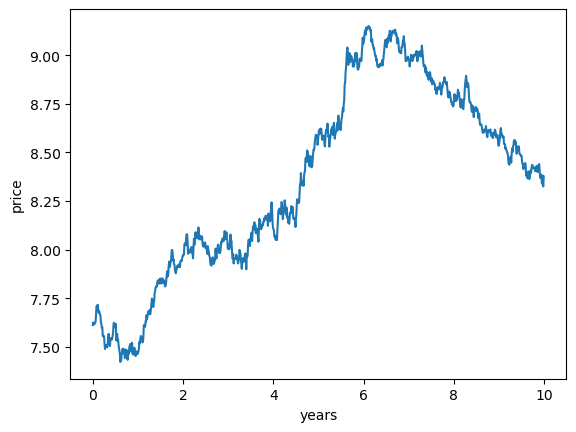

In [8]:
years = np.arange(x.shape[1]-1) * dt

plt.plot(years, x[0,1:].T)

plt.xlabel('years')
plt.ylabel('price')

### 1.3 Optimization

Now we come in the optimization part. We want to minimize the objective value given by the function $\textit{ext_Kalman_filter}$.

First we define a function to print the values at each iteration of the optimization.

In [9]:
def print_value(x):
    global iter_
    global args
    print(' ')
    print('i = ' + str(iter_))
    print('params = ' + str(x))
    print('rmse = ' + str(ext_Kalman_filter(x)))
    iter_ += 1

Here below is the optimization part. We use the fmin function from the scipy library to find the parameters which minimize the objective function. 

In [10]:
start_time = time.time()

y = np.array(x[0, :])[0]

params = 0.07, 1.3, 0.07, 0.3, 0.4, 0.06

iter_ = 1

args = (y, S0, N, dt)

xopt, fopt, _, _, _ = fmin(ext_Kalman_filter, params, maxiter=200, callback=print_value, disp=True, retall=False, full_output=True)

elapsed_time = time.time() - start_time

 
i = 1
params = [0.07175 1.3325  0.063   0.3075  0.41    0.0615 ]
rmse = -6.544350181817707
 
i = 2
params = [0.07175 1.3325  0.063   0.3075  0.41    0.0615 ]
rmse = -6.544350181817707
 
i = 3
params = [0.07175 1.3325  0.063   0.3075  0.41    0.0615 ]
rmse = -6.544350181817707
 
i = 4
params = [0.07175 1.3325  0.063   0.3075  0.41    0.0615 ]
rmse = -6.544350181817707
 
i = 5
params = [0.07175 1.3325  0.063   0.3075  0.41    0.0615 ]
rmse = -6.544350181817707
 
i = 6
params = [0.0695463  1.45407407 0.05893827 0.31222222 0.40592593 0.05881481]
rmse = -6.557522859382065
 
i = 7
params = [0.0695463  1.45407407 0.05893827 0.31222222 0.40592593 0.05881481]
rmse = -6.557522859382065
 
i = 8
params = [0.07405093 1.45106481 0.05370988 0.30569444 0.38685185 0.06387963]
rmse = -6.566649680295494
 
i = 9
params = [0.07405093 1.45106481 0.05370988 0.30569444 0.38685185 0.06387963]
rmse = -6.566649680295494
 
i = 10
params = [0.07405093 1.45106481 0.05370988 0.30569444 0.38685185 0.06387963]
rmse 

/var/folders/1g/dn_fdr795vdgq1fc7vkqm3j00000gn/T/ipykernel_20550/1479398020.py:11: RuntimeWarning: Maximum number of iterations has been exceeded.
  xopt, fopt, _, _, _ = fmin(ext_Kalman_filter, params, maxiter=200, callback=print_value, disp=True, retall=False, full_output=True)


In [11]:
print('Execution time was %0.7f seconds' % elapsed_time)

Execution time was 16.8105960 seconds


### 1.4 Results

Let us compare the results obtain with the simulator which corresponds to the good parameters to the results obtain with the optimization and Extended Kalman Filter.

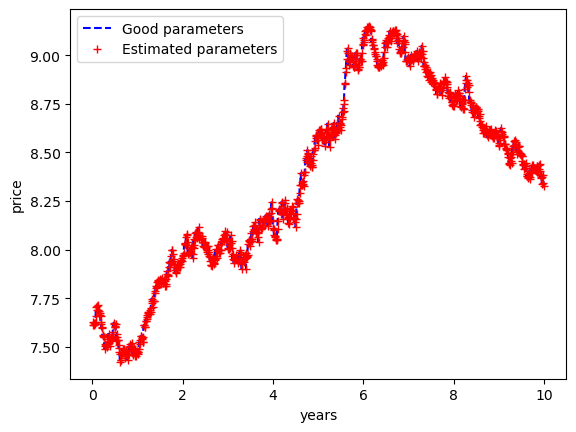

In [12]:
plt.plot(years[1:], x[0,2:].T, 'b--')
plt.plot(years[1:], y_KF[1:], 'r+')

plt.xlabel('years')
plt.ylabel('price')
plt.legend(['Good parameters', 'Estimated parameters'])

plt.show()

Now let us compare the instantaneous variance.

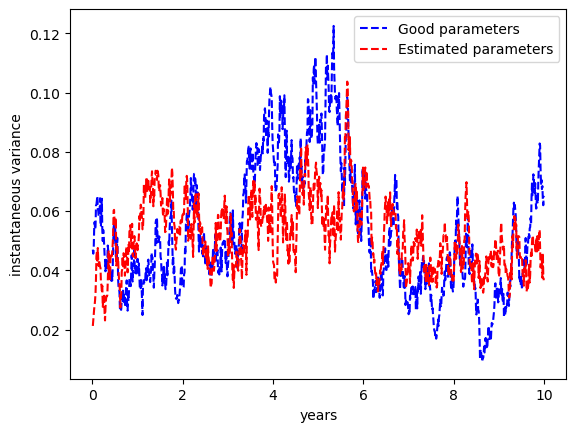

In [13]:
plt.plot(years[1:], x[1,2:].T, 'b--')
plt.plot(years[1:], v_KF[1:], 'r--')


plt.xlabel('years')
plt.ylabel('instantaneous variance')
plt.legend(['Good parameters', 'Estimated parameters'])

plt.show()

Here below are the final estimated parameters and the expected parameters.

In [14]:
print("Final parameters: {}".format(xopt))
print("Good parameters", params_good)

Final parameters: [0.10200754 6.60527698 0.0523154  0.42805059 0.43492163 0.019038  ]
Good parameters (0.02, 1.5, 0.05, 0.18, 0.5, 0.04)


We can thus notice that the estimation is quite ok even if we do not find the good value for each parameter.

## 2. Particle Filter

Now that we estimated the parameters of the Heston model with the Extended Kalman Filter, let us try another technique: the Particle Filter.

Let us initialize some values for our model.

In [15]:
# The number of years where we simulate data

nb_years = 10

# Choice of discretization

N = 1000

dt = nb_years/N

# The stock price
S0 = 2000

### 2.1 Simulation

As before we simulate the Heston model using the good parameters (corresponding to our ground truth reference).

In [16]:
x_pf = heston_sim(params_good, N, dt, S0)

We plot again the price (in log scale) in function of the time (number of years).

Text(0, 0.5, 'price')

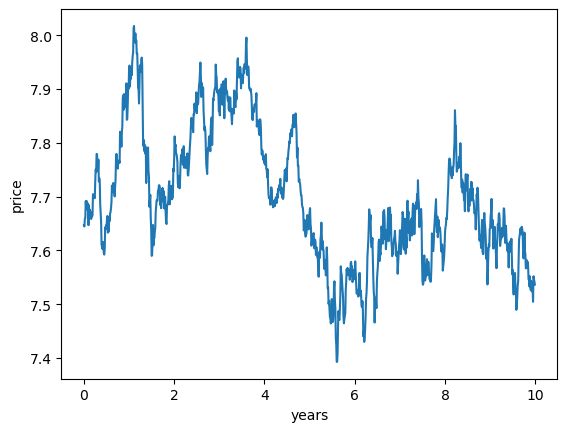

In [17]:
years = np.arange(x_pf.shape[1]-1) * dt

plt.plot(years, x_pf[0,1:].T)
plt.xlabel('years')
plt.ylabel('price')

We stock the prices into a variable.

In [18]:
y = np.array(x_pf[0, :])[0]

### 2.2 Functions definition

Now as before, let us define a bunch of functions.

The proposal distribution function to propose a sample is defined below.

In [19]:
def proposal_distribution_func(N, x_prev, dy, params):
    
    mu, kappa, theta, lambda_, rho = params
    
    m = x_prev + kappa*(theta-x_prev)*dt + lambda_*rho*(dy - (mu-1/2*x_prev)*dt)
    s = lambda_*np.sqrt(x_prev*(1-rho**2)*dt)
    
    return norm.rvs(m, s, N)

As in lecture 12, we define the likelihood function.

In [20]:
def likelihood_func(y, x, x_prev, y_prev, params):
    
    mu, kappa, theta, lambda_, rho = params
    
    m = y_prev + (mu-1/2*x)*dt
    s = np.sqrt(x_prev*dt)
    
    return norm.pdf(y,m,s)

The transition density is defined below.

In [21]:
def transition_func(x, x_prev, params):
        mu, kappa, theta, lambda_, rho = params
        
        m = 1/(1+1/2*lambda_*rho*dt) * (x_prev + kappa*(theta-x_prev)*dt + 1/2*lambda_*rho*x_prev*dt)
        s = 1/(1+1/2*lambda_*rho*dt) * lambda_ * np.sqrt(x_prev*dt)
        
        return norm.pdf(x, m, s)

Same thing for the proposal function.

In [22]:
def proposal_func(x, x_prev, dy, params):
        mu, kappa, theta, lambda_, rho = params
        
        m = x_prev + kappa*(theta-x_prev)*dt + lambda_*rho*(dy - (mu-1/2*x_prev)*dt)
        s = lambda_*np.sqrt(x_prev*(1-rho**2)*dt)
        
        return norm.pdf(x, m, s)

Now, let us define the resampling functions.

Here below is a function to initialize the parameters.

In [23]:
def parameter_states_init(N, boundaries):
    par_states = np.zeros((len(boundaries), N))
    p0, p1, p2, p3, p4 = boundaries
    par_states[0] = np.random.rand(N)*(p0[1]-p0[0])+p0[0]
    par_states[1] = np.random.rand(N)*(p1[1]-p1[0])+p1[0]
    par_states[2] = np.random.rand(N)*(p2[1]-p2[0])+p2[0]
    par_states[3] = np.random.rand(N)*(p3[1]-p3[0])+p3[0]
    par_states[4] = np.random.rand(N)*(p4[1]-p4[0])+p4[0]
    return par_states

Let us define a resampling function, corresponding to the one define in lecture 12.

In [24]:
def resample_state(part, w_):
    N = len(part)
    
    c_sum = np.cumsum(w_)
    c_sum[-1] = 1 
    indexes = np.searchsorted(c_sum, np.random.rand(N))

    part[:] = part[indexes]
    new_w_ = np.ones(len(w_))/len(w_)
    return part, new_w_

In [25]:
def resample(x_pr, w_, par_states):
        par_states[0], _ = resample_state(par_states[0], w_)
        par_states[1], _ = resample_state(par_states[1], w_)
        par_states[2], _ = resample_state(par_states[2], w_)
        par_states[3], _ = resample_state(par_states[3], w_)
        par_states[4], _ = resample_state(par_states[4], w_)
        x_pr, w_ = resample_state(x_pr, w_)
        return x_pr, w_, par_states

Here below is the prediction density.

In [26]:
def prediction_density(y, y_prev, x, mu):
    m = y_prev + (mu-1/2*x)*dt
    s = np.sqrt(x*dt)
    return norm.pdf(y, m, s)

As explained at the end of lecture 12, here is the implementation of the prediction step.

In [27]:
def predict(x_pr, part, y_prev, mu):
    
    y_ = y_prev + (mu-1/2*x_pr)*dt + np.sqrt(part*dt)*norm.rvs()
    py_ = np.array([np.mean(prediction_density(y_[k], y_prev, x_pr, mu)) for k in range(len(y_))])
    
    py_ = py_/sum(py_)
    
    return np.sum(py_ * y_)

Inverse squared function. It is used to check when we should resample.

In [28]:
def sum_square(w_):
        return 1/np.sum(np.square(w_))

Here below is the main function defined for the Particle Filter function.

In [29]:
def particle_filter(params):
    global y_PF, v_PF
    
    mu, kappa, theta, lambda_, rho, v_0 = params
        
    par_states = parameter_states_init(N, params[:-1])
    
    y_PF = np.zeros(N)
    v_PF = np.zeros(N)
    
    y_PF[0] = y[0]
    v_PF[0] = v_0
    
    w_ = np.array([1/N] * N)
    
    part = norm.rvs(v_0, 0.04, N)
    part = np.maximum(1e-6, part)
    
    params_steps = np.zeros((len(params)-1, len(y)))
    params_steps.transpose()[0] = np.mean(par_states, axis=1)
    
    for i in range(1, N):
        
        print("Iter: ", i)
        
        dy = y[i] - y[i-1]
        
        x_pr = proposal_distribution_func(N, part, dy, par_states)
        x_pr = np.maximum(1e-4, x_pr)
        
        L_ = likelihood_func(y[i], x_pr, part, y[i-1], par_states)
        I_ = proposal_func(x_pr, part, dy, par_states)
        T_ = transition_func(x_pr, part, par_states)
        
        w_ = w_ * (L_*T_/I_)
        w_ = w_/sum(w_)
        
        if sum_square(w_) < 0.65*N:
            print('New resampling since: {}'.format(sum_square(w_)))
            x_pr, w_, par_states = resample(x_pr, w_, par_states)
        
        y_ = predict(x_pr, part, y[i-1], np.mean(par_states[0]))
        y_PF[i] = y_
        
        v_PF[i] = np.sum(x_pr * w_)
        part = x_pr
        params_steps.transpose()[i] = np.sum(np.multiply(par_states, w_[np.newaxis, :]), axis=1)
        
        
    return (v_PF, params_steps, y_PF)

### 2.3 Optimization

Let us initialize the parameters and give them a certain interval of search.

In [30]:
mu = (0.01, 0.04)
kappa = (1.3, 1.8)
theta = (0.02, 0.1)
lambda_ = (0.1, 0.3)
rho = (0.4, 0.9)
v_0 = params_good[-1]
params = [mu, kappa, theta, lambda_, rho, v_0]

Let us run the Particle Filter algorithm.

In [31]:
start_time = time.time()

v, par_steps, y_obs = particle_filter(params)

elapsed_time = time.time() - start_time

Iter:  1
New resampling since: 32.11351818056739
Iter:  2
New resampling since: 375.3093417521453
Iter:  3
New resampling since: 644.0893485111169
Iter:  4
New resampling since: 128.23759604672307
Iter:  5
New resampling since: 38.2793347073662
Iter:  6
New resampling since: 205.47556846841238
Iter:  7
New resampling since: 71.5509222810073
Iter:  8
New resampling since: 394.9965954682091
Iter:  9
New resampling since: 592.7041333314563
Iter:  10
New resampling since: 538.090369201078
Iter:  11
New resampling since: 146.3249273837911
Iter:  12
New resampling since: 172.0807140243326
Iter:  13
New resampling since: 541.9696632735153
Iter:  14
New resampling since: 544.192755680897
Iter:  15
Iter:  16
New resampling since: 117.23804210816567
Iter:  17
New resampling since: 434.7449101710526
Iter:  18
New resampling since: 595.3278825637994
Iter:  19
New resampling since: 505.8547229610821
Iter:  20
Iter:  21
New resampling since: 2.478880806340895
Iter:  22
New resampling since: 590.3614

In [32]:
print('Execution time was %0.7f seconds' % elapsed_time)

Execution time was 44.0163209 seconds


### 2.4 Results

Let us plot the results and compare to see if we obtained correct results.

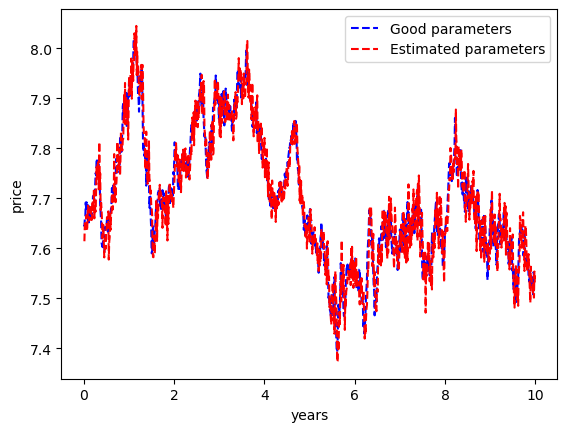

In [33]:
years = np.arange(x_pf.shape[-1]-1) * dt

plt.plot(years, x_pf[0,1:].T, 'b--')
plt.plot(years[1:], y_obs[1:], 'r--')

plt.xlabel('years')
plt.ylabel('price')
plt.legend(['Good parameters', 'Estimated parameters'])

plt.show()

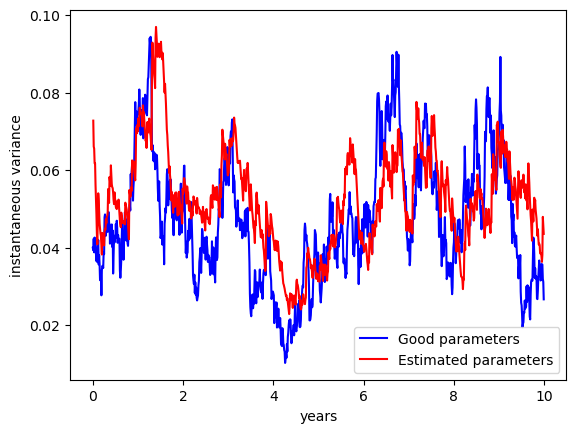

In [34]:
plt.plot(years[:], np.array(x_pf[1,1:])[0], 'b-')
plt.plot(years[1:], v[1:], 'r-')

plt.xlabel('years')
plt.ylabel('instantaneous variance')
plt.legend(['Good parameters', 'Estimated parameters'])

plt.show()

Let us observe the convergence of the different parameters and compare them with the truth values. The dashed horizontal lines correspond to the parameters expected.

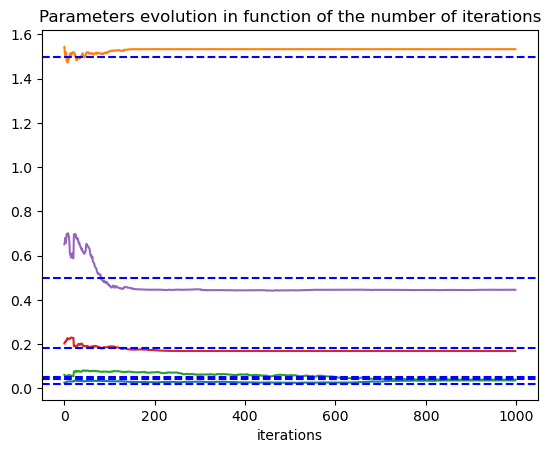

In [35]:
plt.plot(par_steps[:,:-2].transpose())

plt.title('Parameters evolution in function of the number of iterations')
plt.xlabel('iterations')

for i in range(len(params_good)):
    plt.axhline(y=params_good[i], color='b', linestyle='--')

plt.show()

The final values obtained are the following.

In [36]:
print("Final parameters: {}, {}, {}, {}, {}, {}".format(par_steps[0,-2], par_steps[1,-2], par_steps[2,-2], par_steps[3,-2], par_steps[4,-2], params_good[-1]))

Final parameters: 0.035584569755089085, 1.5334029959738609, 0.039155382275879363, 0.16844423018391558, 0.44534579011838016, 0.04


In [37]:
print("Good parameters", params_good)

Good parameters (0.02, 1.5, 0.05, 0.18, 0.5, 0.04)


We can thus notice that they are not too far from the expected values.

## 3. Conclusion

In conclusion, we can notice that the Particle Filter seems better than the Extended Kalman Filter at estimating parameters but take more time. But in general, the time to perform the algorithms is pretty short.

Both Extended Kalman Filter (EKF) and Particle Filter (PF) are popular methods for parameter estimation in Heston stochastic volatility models. However, each method has its own advantages and limitations, which should be carefully considered when choosing the appropriate method for a particular application.

EKF is a widely used method for parameter estimation, as it provides a computationally efficient way to estimate parameters in a Heston model. The EKF method approximates the nonlinear dynamics of the Heston model using a linear approximation, and updates the estimates based on new observations. EKF can produce accurate estimates of model parameters when the measurement noise is small and the model is well-behaved. However, it can be sensitive to the choice of initial conditions, and its accuracy can deteriorate if the measurement noise is large or the model exhibits nonlinear behavior.

On the other hand, PF is a powerful method for parameter estimation in Heston models that can handle nonlinear behavior and measurement noise. The PF method uses a set of part to represent the possible states of the system, and updates these part based on new observations. PF can produce accurate estimates of model parameters even in the presence of large measurement noise or nonlinear behavior. However, PF can be computationally expensive, and its performance can be sensitive to the choice of parameters such as the number of part.

In summary, both EKF and PF are viable methods for parameter estimation in Heston stochastic volatility models. EKF is a computationally efficient method that can produce accurate estimates under certain conditions, while PF is a more robust method that can handle nonlinear behavior and measurement noise. The choice of method depends on the specific application and the desired trade-off between computational efficiency and accuracy.

Here below is the comparison between the different parameters obtained for the different methods.

In [38]:
print("Ground truth:            {}, {}, {}, {}, {}, {}".format(params_good[0], params_good[1], params_good[2], params_good[3],params_good[4], params_good[5]))
print("Extended Kalman Filter:  {}, {}, {}, {}, {}, {}".format(round(xopt[0],4), round(xopt[1],4), round(xopt[2],4), round(xopt[3],4), round(xopt[4],4), round(xopt[5],4)))
print("Particle Filter:        {}, {}, {}, {}, {}, {}".format(round(par_steps[0,-2],4), round(par_steps[1,-2],4), round(par_steps[2,-2],4), round(par_steps[3,-2],4), round(par_steps[4,-2],4), params_good[-1]))

Ground truth:            0.02, 1.5, 0.05, 0.18, 0.5, 0.04
Extended Kalman Filter:  0.102, 6.6053, 0.0523, 0.4281, 0.4349, 0.019
Particle Filter:        0.0356, 1.5334, 0.0392, 0.1684, 0.4453, 0.04


It seems indeed that in this case the Particle Filter method is better.